In [202]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn import feature_selection
from sklearn.feature_selection import f_regression
import itertools
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [203]:
master = pd.read_pickle("Combined_Social_Data_Pickle.pkl")

In [204]:
master.dtypes

Facebook                                       int64
Instagram                                      int64
Twitter                                        int64
Youtube                                        int64
age                                            int64
artist_name_x                                 object
artist_name_y                                 object
count_of_followers                           float64
created                               datetime64[ns]
created_12am-6am                               int64
created_12pm-6pm                               int64
created_6am-12pm                               int64
created_6pm-12am                               int64
crowdtangle_score                             object
description                                   object
description_length                             int64
facebook                                      object
genre_electronic                             float64
genre_hip_hop                                 

In [205]:
sorted(master.created)[:5]

[Timestamp('2006-04-02 19:09:00'),
 Timestamp('2006-04-03 16:40:00'),
 Timestamp('2006-04-04 16:33:00'),
 Timestamp('2006-04-04 16:56:00'),
 Timestamp('2006-05-02 19:17:00')]

In [206]:
sorted(master.created)[-5:]

[Timestamp('2019-07-06 16:55:14'),
 Timestamp('2019-07-06 16:55:14'),
 Timestamp('2019-07-06 16:55:14'),
 Timestamp('2019-07-06 16:55:14'),
 Timestamp('2019-07-06 16:55:14')]

In [208]:
#Only use data from 1/1/16 to 6/1/19
master = master[(master['created']>pd.to_datetime('01-01-2016')) & (master['created']<pd.to_datetime('06-01-2019'))]
master['time_since_last_post'] = pd.to_timedelta(master['time_since_last_post'])
master['time_since_last_post'] = [x.total_seconds() for x in master['time_since_last_post']]

In [209]:
len(master)

681571

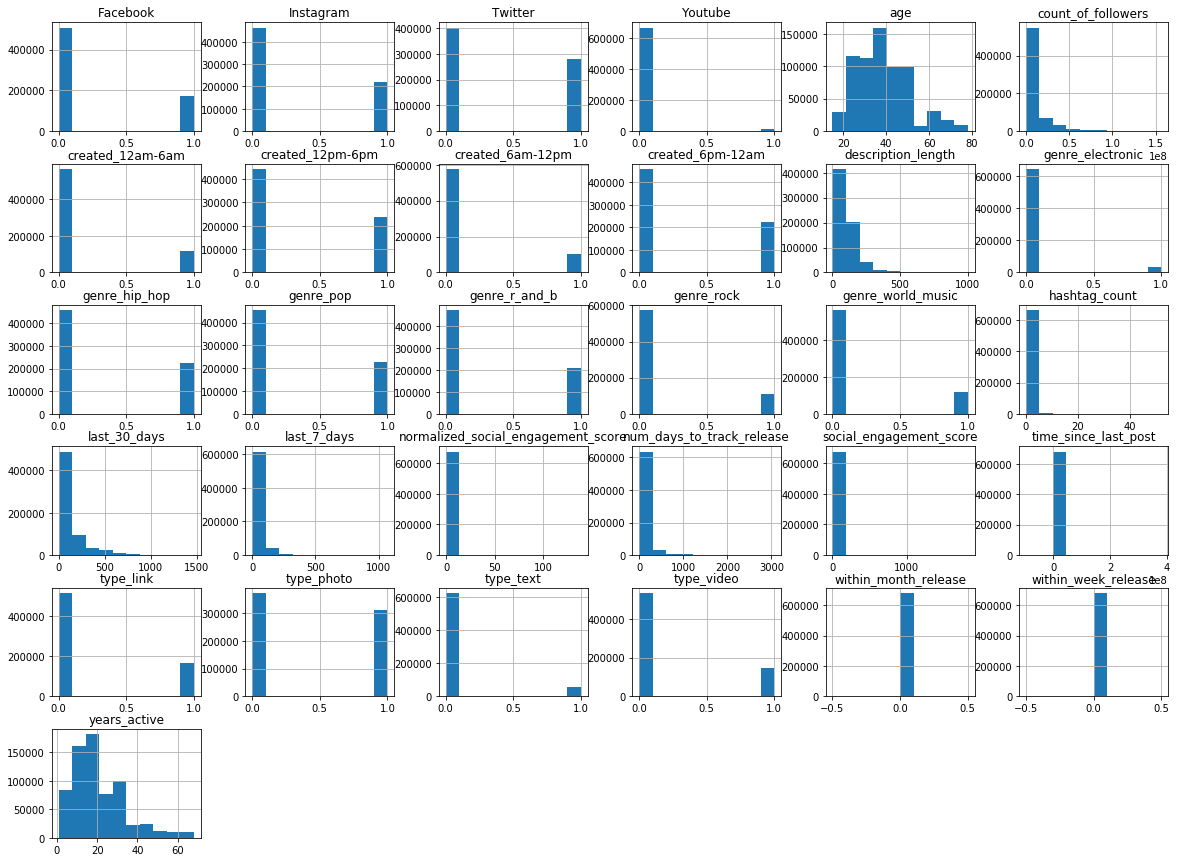

In [210]:
master.hist(figsize = (20,15))
plt.show()

In [211]:
# Check NAs for potential features
master.social_engagement_score.isna().sum()

5646

In [212]:
master.age.isna().sum()

0

In [213]:
master.normalized_social_engagement_score.isna().sum()

5646

In [214]:
# Normalize data
to_norm_list = ['count_of_followers', 'age', 'description_length', 
                'hashtag_count', 'last_30_days', 'last_7_days', 'num_days_to_track_release','years_active','time_since_last_post']

In [215]:
for feature in to_norm_list:
    master[feature] = preprocessing.scale(master[feature])

C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


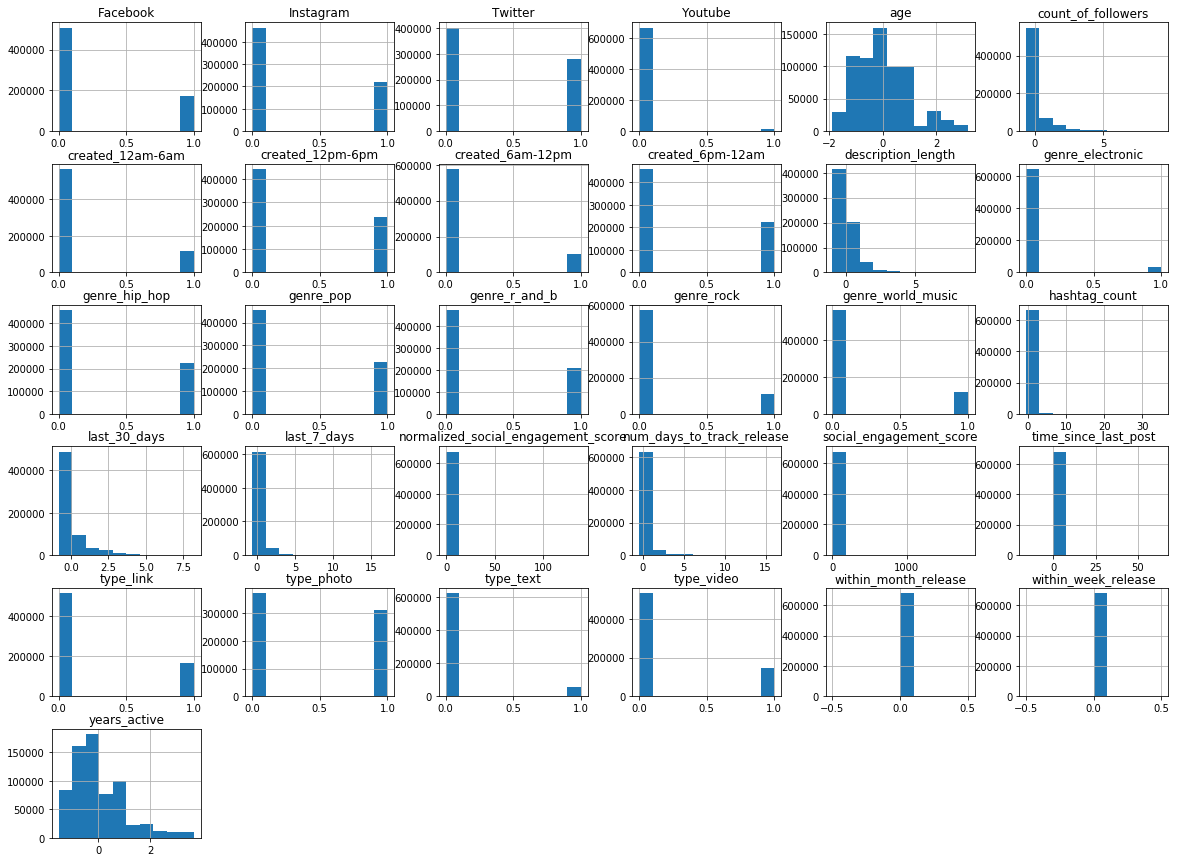

In [216]:
master.hist(figsize = (20,15))
plt.show()

In [217]:
master.head()

,Facebook,Instagram,Twitter,Youtube,age,artist_name_x,artist_name_y,count_of_followers,created,created_12am-6am,...,type_photo,type_text,type_video,within_month_release,within_week_release,years_active,youtube,social_platform,normalized_social_engagement_score,num_days_to_track_release
43,1,0,0,0,-0.995686,21Savage,21 Savage,NaN,2016-01-01 17:24:50,0,...,1,0,0,0,0,-1.214101,21 Savage,Facebook,NaN,0.142351
44,1,0,0,0,-0.995686,21Savage,21 Savage,NaN,2016-01-05 11:17:42,0,...,0,0,1,0,0,-1.214101,21 Savage,Facebook,NaN,0.120782
45,1,0,0,0,-0.995686,21Savage,21 Savage,NaN,2016-01-06 16:03:56,0,...,0,0,0,0,0,-1.214101,21 Savage,Facebook,NaN,0.115389
46,1,0,0,0,-0.995686,21Savage,21 Savage,NaN,2016-01-07 16:50:41,0,...,1,0,0,0,0,-1.214101,21 Savage,Facebook,NaN,0.109997
47,1,0,0,0,-0.995686,21Savage,21 Savage,NaN,2016-01-11 13:43:22,0,...,0,0,1,0,0,-1.214101,21 Savage,Facebook,NaN,0.088427


In [218]:
# Removing NaN of normalized_socila_engagement_score
master = master[pd.notnull(master['normalized_social_engagement_score'])]

In [219]:
master.shape

(675925, 42)

In [220]:
# Filling NaN of 6 features with 0
master['genre_electronic'].fillna(0,inplace = True)
master['genre_world_music'].fillna(0,inplace=True)
master['hashtag_count'].fillna(0,inplace=True)
master['last_30_days'].fillna(0,inplace=True)
master['last_7_days'].fillna(0,inplace=True)
master['time_since_last_post'].fillna(0,inplace=True)

In [221]:
master.isna().sum()

Facebook                                  0
Instagram                                 0
Twitter                                   0
Youtube                                   0
age                                       0
artist_name_x                             0
artist_name_y                             0
count_of_followers                        0
created                                   0
created_12am-6am                          0
created_12pm-6pm                          0
created_6am-12pm                          0
created_6pm-12am                          0
crowdtangle_score                      9179
description                           17121
description_length                        0
facebook                                  0
genre_electronic                          0
genre_hip_hop                             0
genre_pop                                 0
genre_r_and_b                             0
genre_rock                                0
genre_world_music               

In [222]:
# Drop unwanted features for modeling
master = master.drop(['crowdtangle_score', 'description', 'artist_name_x','artist_name_y','created','musicbrainz','social_platform','within_month_release',
       'within_week_release',], axis=1)

In [223]:
master.shape

(675925, 33)

In [282]:
prelim_features = master.columns

In [225]:
feature_list = ['count_of_followers','created_12am-6am','created_12pm-6pm','created_6am-12pm','created_6pm-12am','description_length','genre_electronic',
                'genre_hip_hop','genre_pop','genre_r_and_b','genre_rock','genre_world_music','hashtag_count','last_30_days',
               'last_7_days','time_since_last_post','type_link','type_photo','type_text','type_video','years_active','num_days_to_track_release']
plot_list = ['count_of_followers','created_12am-6am','created_12pm-6pm','created_6am-12pm','created_6pm-12am','description_length','genre_electronic',
                'genre_hip_hop','genre_pop','genre_r_and_b','genre_rock','genre_world_music','hashtag_count','last_30_days',
               'last_7_days','type_link','type_photo','type_text','type_video','years_active','num_days_to_track_release']

In [226]:
main_feature_list = ['count_of_followers','description_length','hashtag_count','last_30_days',
               'last_7_days','time_since_last_post','years_active','num_days_to_track_release','normalized_social_engagement_score']

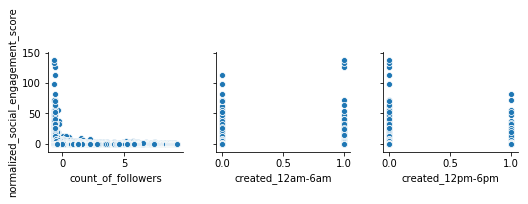

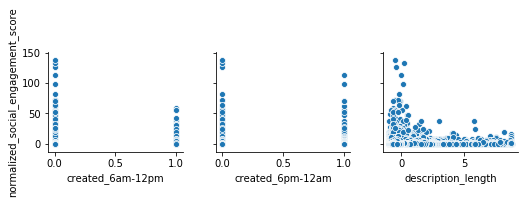

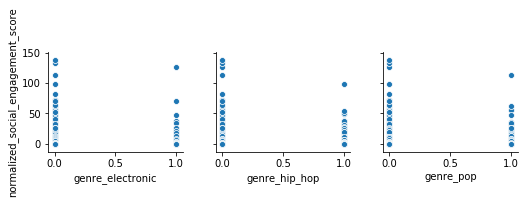

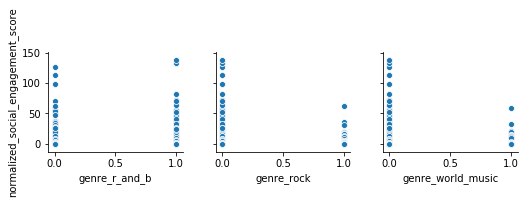

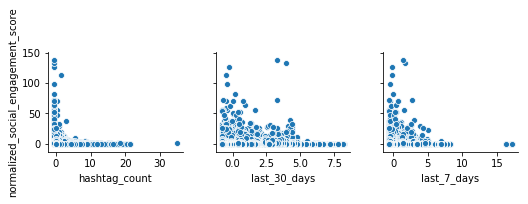

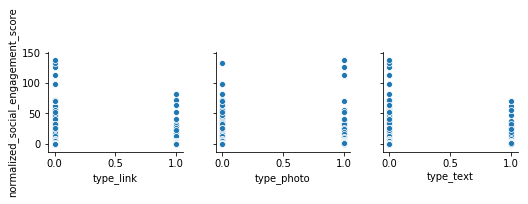

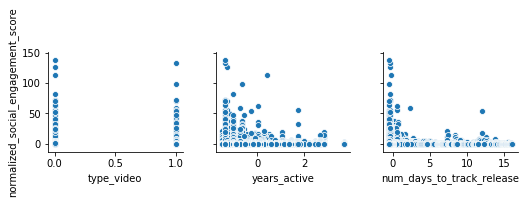

In [25]:
for i in range(7):
    sns_plot  = sns.pairplot(data=master,y_vars='normalized_social_engagement_score',x_vars=plot_list[3*i:3*(i+1)])
    plt.show()


In [26]:
import pandas as pd
import numpy as np

corr = master.corr()
corr.style.background_gradient(cmap='coolwarm')

,Facebook,Instagram,Twitter,Youtube,age,count_of_followers,created_12am-6am,created_12pm-6pm,created_6am-12pm,created_6pm-12am,description_length,genre_electronic,genre_hip_hop,genre_pop,genre_r_and_b,genre_rock,genre_world_music,hashtag_count,last_30_days,last_7_days,social_engagement_score,type_link,type_photo,type_text,type_video,years_active,normalized_social_engagement_score,num_days_to_track_release
Facebook,1,-0.399956,-0.492253,-0.0688464,0.0757326,0.107629,-0.160347,0.105037,0.113823,-0.0652531,0.0761306,-0.0479663,-0.119408,-0.0116888,-0.0395251,0.0818943,0.112554,0.021271,-0.101061,-0.0866583,-0.0108833,-0.103942,0.114237,-0.140015,0.0653845,0.0841346,-0.000767153,0.0446046
Instagram,-0.399956,1,-0.571839,-0.0799772,-0.0276026,0.0702501,-0.0687044,0.0487808,0.0373653,-0.023035,-0.0654401,-0.0104569,0.133571,-0.0649701,0.0312911,-0.0594948,-0.048933,0.0855819,-0.00972543,-0.0428342,-0.00969471,-0.389574,0.368548,-0.207317,0.102309,-0.0307675,-0.0170715,-0.0318415
Twitter,-0.492253,-0.571839,1,-0.0984334,-0.0466118,-0.173767,0.214235,-0.148388,-0.142884,0.0883027,0.00824955,0.0443056,-0.0130024,0.0681867,0.00619745,-0.0230604,-0.0539532,-0.0997532,0.114561,0.118754,-0.0156362,0.476125,-0.424489,0.328461,-0.207273,-0.051995,0.017141,-0.0144011
Youtube,-0.0688464,-0.0799772,-0.0984334,1,0.0236824,0.0508692,-0.0304365,0.039008,0.0283611,-0.03695,-0.0590657,0.0344543,-0.0314663,0.0152475,-0.0031293,0.0284922,0.00182045,2.58554e-05,-0.0671364,-0.00615725,0.146549,-0.0670592,-0.106891,-0.0356865,0.22382,0.0276242,-0.00138303,0.0210872
age,0.0757326,-0.0276026,-0.0466118,0.0236824,1,-0.0547101,-0.0553353,0.0556338,0.0533176,-0.0529963,0.122043,-0.126336,-0.0794753,-0.190916,-0.268542,0.482122,0.0975273,0.12345,0.0386398,0.00849598,-0.00720764,0.0390726,0.00505387,-0.0828274,0.00902183,0.946783,-0.218018,0.218217
count_of_followers,0.107629,0.0702501,-0.173767,0.0508692,-0.0547101,1,-0.0168828,0.0323336,-0.00946995,-0.0120059,-0.088616,-0.0898907,0.0716106,0.113079,0.224458,-0.137909,0.0218781,-0.0421794,-0.00873512,-0.0134365,-0.000881798,-0.0901048,0.0636851,-0.0758708,0.0686625,0.0236176,-0.118128,-0.0941422
created_12am-6am,-0.160347,-0.0687044,0.214235,-0.0304365,-0.0553353,-0.0168828,1,-0.332817,-0.193594,-0.316972,-0.0546123,0.0115086,0.077611,-0.028307,0.0168393,-0.0703621,-0.0379103,-0.0388092,0.120419,0.133655,-0.00431774,0.0979895,-0.0835092,0.0962633,-0.0667288,-0.0534118,0.0105408,-0.0321981
created_12pm-6pm,0.105037,0.0487808,-0.148388,0.039008,0.0556338,0.0323336,-0.332817,1,-0.311158,-0.509461,0.0373626,-0.00534113,-0.0526996,0.0238535,-0.0101351,0.0613994,0.0206529,0.0264151,-0.0883479,-0.0794345,0.00115485,-0.0784439,0.0552486,-0.0561525,0.0533104,0.0476887,-0.0119513,0.0229562
created_6am-12pm,0.113823,0.0373653,-0.142884,0.0283611,0.0533176,-0.00946995,-0.193594,-0.311158,1,-0.296345,0.0298846,0.0131419,-0.0480019,-0.00620081,-0.024211,0.0710909,0.00149355,-0.00555191,-0.0117145,-0.0163288,0.0093905,-0.0494197,0.0425132,-0.0239624,0.0165286,0.0551686,-0.0118858,0.027796
created_6pm-12am,-0.0652531,-0.023035,0.0883027,-0.03695,-0.0529963,-0.0120059,-0.316972,-0.509461,-0.296345,1,-0.0170159,-0.0139183,0.028027,0.00328135,0.0153577,-0.0604269,0.00834238,0.00862218,0.00196371,-0.0141869,-0.00491538,0.0388914,-0.0216601,-0.00192198,-0.0132206,-0.0478921,0.0127988,-0.0187917


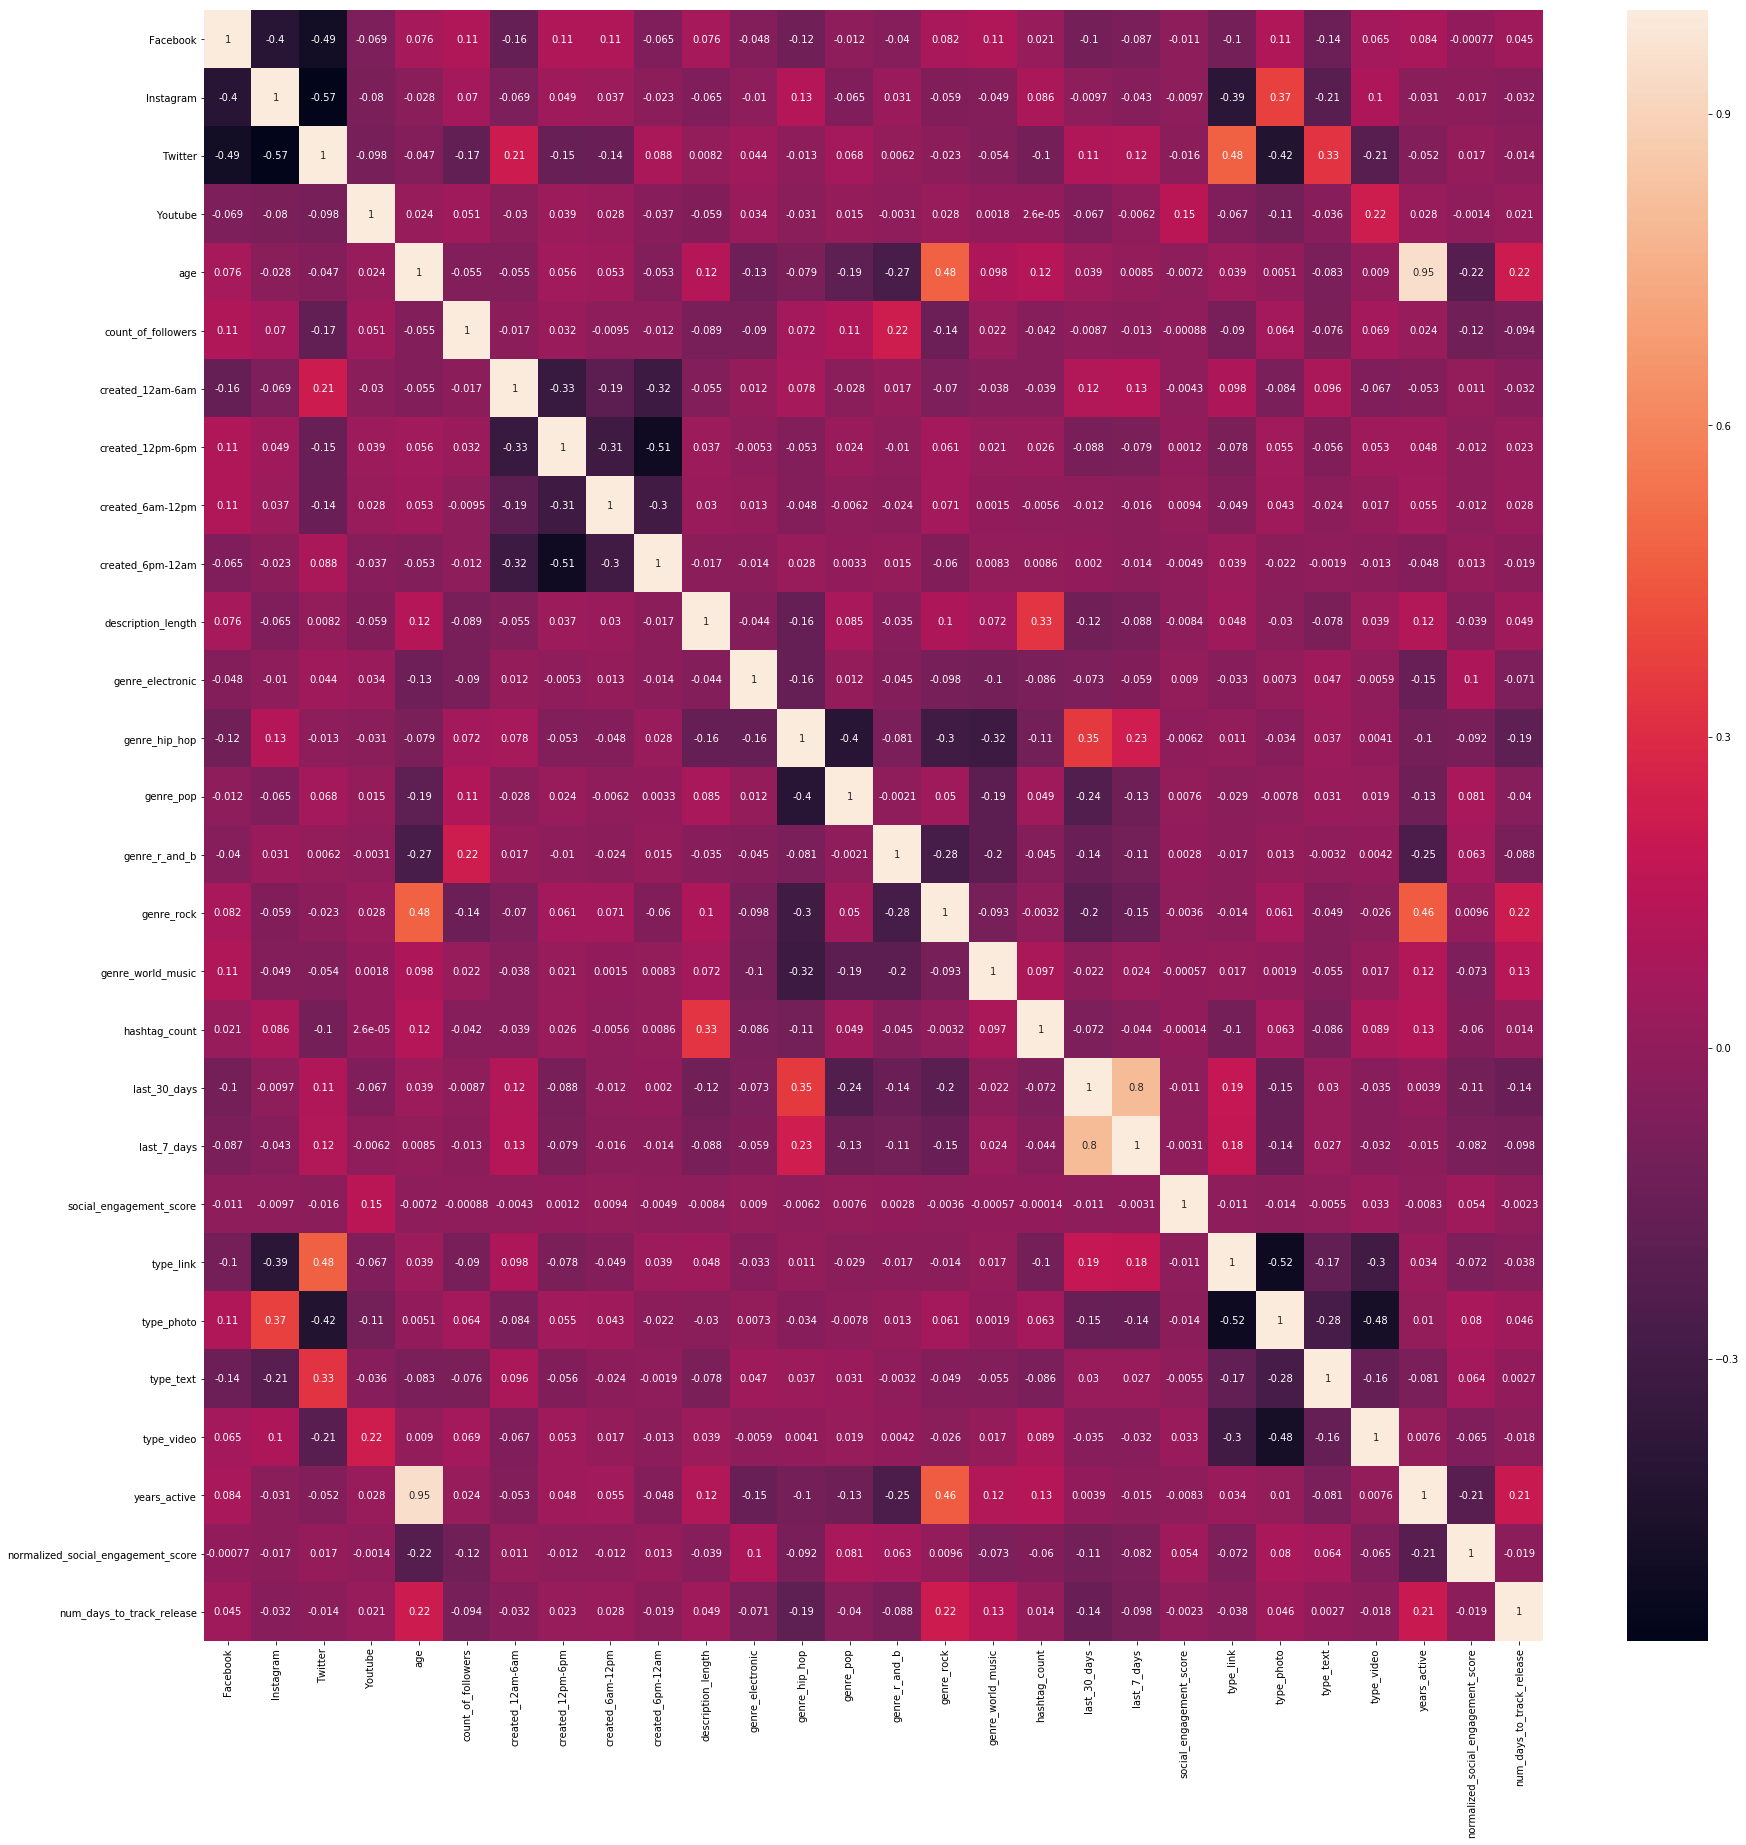

In [27]:
## correlation heatmap - No strong correlation observed except for years_Active and age
fig, axs = plt.subplots(figsize = (30, 30))
sns.heatmap(master.corr(), annot = True)
## - No strong correlation observed except for years_Active and age - Need to take a decision on this during feature selection

In [227]:


skews = ['years_active','num_days_to_track_release','time_since_last_post','last_7_days','last_30_days',
        'hashtag_count','description_length','age','time_since_last_post']
master_skew = master
# master_skew['time_since_last_post'] = pd.to_timedelta(master_skew['time_since_last_post'])
# master_skew['time_since_last_post'] = [x.total_seconds() for x in master_skew['time_since_last_post']]

pt = PowerTransformer(method='yeo-johnson', standardize=False)
for skew in skews:
    master_skew[skew] = pt.fit_transform(np.array(master_skew[skew]).reshape(-1, 1))

In [229]:
from sklearn.metrics import r2_score

**Facebook**

In [237]:
# Base model for FB
df_fb = master[master['Facebook'] == 1]
df_fb.drop(['Facebook', 'Instagram', 'Twitter', 'Youtube', 'facebook', 'instagram', 'twitter', 'youtube', 'social_engagement_score'], inplace = True, axis = 1)

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(df_fb.drop('normalized_social_engagement_score', axis=1), df_fb['normalized_social_engagement_score'], test_size = 0.2, random_state = 0)


sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

# Fitting Multiple Linear Regression to the Training set
fb_regressor = LinearRegression()
fb_regressor.fit(X_train, y_train)

# Predicting the Test set results
y_pred = fb_regressor.predict(X_test)
print('Linear Regression MSE: ',mean_squared_error(y_pred,y_test))
print('Linear Regression R2 Score: ',r2_score(y_pred,y_test))
print(fb_regressor.coef_)

C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


Linear Regression MSE:  0.9858239681133328
Linear Regression R2 Score:  -8.535942088922633
[-3.82698992e-02 -1.37081598e-01 -2.52147229e+11 -4.93850828e+11
 -4.14744253e+11 -4.44844783e+11 -5.32178061e-02  9.48156441e-02
  2.67236060e-02  1.96871256e-02  8.15565315e-02  4.14829844e-02
  8.74699602e-04 -2.48858956e-02  5.29338578e-02 -8.76040503e-02
  9.71254609e-03 -9.36130170e+10 -1.24142179e+11 -3.34515407e+10
 -1.09738896e+11 -1.48274569e-01 -2.09248525e-02]


C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # This is added back by InteractiveShellApp.init_path()


In [238]:
df_fb.columns

Index(['age', 'count_of_followers', 'created_12am-6am', 'created_12pm-6pm',
       'created_6am-12pm', 'created_6pm-12am', 'description_length',
       'genre_electronic', 'genre_hip_hop', 'genre_pop', 'genre_r_and_b',
       'genre_rock', 'genre_world_music', 'hashtag_count', 'last_30_days',
       'last_7_days', 'time_since_last_post', 'type_link', 'type_photo',
       'type_text', 'type_video', 'years_active',
       'normalized_social_engagement_score', 'num_days_to_track_release'],
      dtype='object')

In [239]:
# def compress(data, selectors):
#     # compress('ABCDEF', [1,0,1,0,1,1]) --> A C E F
#     return (d for d, s in izip(data, selectors) if s)

In [301]:
model = feature_selection.SelectKBest(score_func=feature_selection.f_regression, k="all")
results = model.fit(X_train, y_train)
feature_list = df_fb.columns.drop('normalized_social_engagement_score')
in_feature = list(itertools.compress(feature_list,results.pvalues_<1e-3))
out_feature = list(itertools.compress(feature_list,results.pvalues_>=1e-3))
# print(results.scores_)
# print(results.pvalues_>1e-3)
print("Selected features: ", list(in_feature))
print("Dropped features: ", list(out_feature))


Selected features:  ['age', 'count_of_followers', 'created_12am-6am', 'created_12pm-6pm', 'description_length', 'genre_electronic', 'genre_hip_hop', 'genre_pop', 'genre_r_and_b', 'genre_rock', 'genre_world_music', 'hashtag_count', 'last_30_days', 'time_since_last_post', 'type_link', 'type_photo', 'type_text', 'type_video', 'years_active', 'num_days_to_track_release']
Dropped features:  ['created_6am-12pm', 'created_6pm-12am', 'last_7_days']


In [242]:
# Base model for FB
df_fb = master_skew[master_skew['Facebook'] == 1]
df_fb.drop(['Facebook', 'Instagram', 'Twitter', 'Youtube', 'facebook', 'instagram', 'twitter', 'youtube', 'social_engagement_score'], inplace = True, axis = 1)

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(df_fb.drop('normalized_social_engagement_score', axis=1), df_fb['normalized_social_engagement_score'], test_size = 0.2, random_state = 0)

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

# Fitting Multiple Linear Regression to the Training set
fb_regressor = LinearRegression()
fb_regressor.fit(X_train, y_train)

# Predicting the Test set results
y_pred = fb_regressor.predict(X_test)
print('Linear Regression without skew MSE: ',mean_squared_error(y_pred,y_test))
print('Linear Regression without skew R2 Score: ',r2_score(y_pred,y_test))
print(fb_regressor.coef_)

C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


Linear Regression without skew MSE:  0.9858239681133328
Linear Regression without skew R2 Score:  -8.535942088922633
[-3.82698992e-02 -1.37081598e-01 -2.52147229e+11 -4.93850828e+11
 -4.14744253e+11 -4.44844783e+11 -5.32178061e-02  9.48156441e-02
  2.67236060e-02  1.96871256e-02  8.15565315e-02  4.14829844e-02
  8.74699602e-04 -2.48858956e-02  5.29338578e-02 -8.76040503e-02
  9.71254609e-03 -9.36130170e+10 -1.24142179e+11 -3.34515407e+10
 -1.09738896e+11 -1.48274569e-01 -2.09248525e-02]


C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.


In [244]:
df_fb = master_skew[master_skew['Facebook'] == 1]
df_fb.drop(['Facebook', 'Instagram', 'Twitter', 'Youtube', 'facebook', 'instagram', 'twitter', 'youtube', 'social_engagement_score'], inplace = True, axis = 1)

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(df_fb.drop('normalized_social_engagement_score', axis=1), df_fb['normalized_social_engagement_score'], test_size = 0.2, random_state = 0)

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

# Fitting Multiple Linear Regression to the Training set
fb_regressor = LinearRegression()
fb_regressor.fit(X_train[:,results.pvalues_<1e-3], y_train)

# Predicting the Test set results
y_pred = fb_regressor.predict(X_test[:,results.pvalues_<1e-3])
print('Linear Regression selected features without skew MSE: ',mean_squared_error(y_pred,y_test))
print('Linear Regression selected features without skew R2 Score: ',r2_score(y_pred,y_test))
print(fb_regressor.coef_)

C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


Linear Regression selected features without skew MSE:  0.9861357808141556
Linear Regression selected features without skew R2 Score:  -8.56482462431318
[-4.06037490e-02 -1.33262882e-01 -2.15403257e+11 -4.21884775e+11
 -3.54305948e+11 -3.80020100e+11 -5.45744038e-02  8.81079531e-02
  6.45222507e-03  7.26015990e-02  2.95129668e-02 -1.48257086e-02
 -2.52451044e-02  5.13553305e-02 -8.87077969e-02  9.78977828e-03
 -5.00373687e-02  5.37570633e-02 -1.47184492e-01 -2.41016985e-02]


C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


In [103]:
%%time
xgb_clf = xgb.XGBRegressor() 
parameters = {'n_estimators': [50, 100,200], 'max_depth':[3,5,7]}
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train[:,results.pvalues_<1e-3], y_train)
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters=grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))


C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:34:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best score: 0.360
Best parameters set:
	max_depth: 5
	n_estimators: 100
Wall time: 14min 58s


In [302]:
%%time
# best_xgb = grid_search.best_estimator_
best_xgb = xgb.XGBRegressor(n_estimators = 100, max_depth = 5) 
best_xgb.fit(X_train[:,results.pvalues_<1e-3],y_train)
y_pred = best_xgb.predict(X_test[:,results.pvalues_<1e-3])
print('XGBoost Regression MSE: ',mean_squared_error(y_pred,y_test))
print('XGBoost Regression R2 Score: ',r2_score(y_pred,y_test))
# print(fb_regressor.coef_)

C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:49:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost Regression MSE:  0.4998506777102089
XGBoost Regression R2 Score:  -0.7680822263674008
Wall time: 48.1 s


In [303]:
for i in range(max(len(best_xgb.feature_importances_),len(in_feature))):
    print(in_feature[i], ': ', best_xgb.feature_importances_[i])

age :  0.024372216
count_of_followers :  0.027831232
created_12am-6am :  0.028008923
created_12pm-6pm :  0.028045544
description_length :  0.029726181
genre_electronic :  0.19441353
genre_hip_hop :  0.011785695
genre_pop :  0.037905525
genre_r_and_b :  0.1530208
genre_rock :  0.012930128
genre_world_music :  0.015773367
hashtag_count :  0.03416954
last_30_days :  0.037914556
time_since_last_post :  0.045300078
type_link :  0.08416675
type_photo :  0.028479211
type_text :  0.013932643
type_video :  0.08768124
years_active :  0.097082146
num_days_to_track_release :  0.007460727


In [37]:
# Ridge Regression
ridge = Ridge()
parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]}
ridge_grid_search = GridSearchCV(ridge, parameters, cv=5)
ridge_grid_search.fit(X_train[:,results.pvalues_<1e-3], y_train)
print("Best score: %0.3f" % ridge_grid_search.best_score_)
print("Best parameters set:")
best_parameters=ridge_grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.094
Best parameters set:
	alpha: 20


In [38]:
best_ridge = ridge_grid_search.best_estimator_
best_ridge.fit(X_train[:,results.pvalues_<1e-3],y_train)
y_pred = best_ridge.predict(X_test[:,results.pvalues_<1e-3])
print('Ridge Regression MSE: ',mean_squared_error(y_pred,y_test))

Ridge Regression MSE:  0.9860963248962431


In [41]:
# Lasso Regression
lasso = Lasso()
parameters = {'alpha': [ 1e-3,1e-2, 1, 5, 10, 20]}
lasso_grid_search = GridSearchCV(lasso, parameters, cv=5)
lasso_grid_search.fit(X_train[:,results.pvalues_<1e-3], y_train)
print("Best score: %0.3f" % lasso_grid_search.best_score_)
print("Best parameters set:")
best_parameters=lasso_grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.094
Best parameters set:
	alpha: 0.001


In [42]:
best_lasso = lasso_grid_search.best_estimator_
best_lasso.fit(X_train[:,results.pvalues_<1e-3],y_train)
y_pred = best_lasso.predict(X_test[:,results.pvalues_<1e-3])
print('Lasso Regression MSE: ',mean_squared_error(y_pred,y_test))

Lasso Regression MSE:  0.9860865646889911


In [43]:
# Random Forest Regressor
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [50, 100, 200, 300]
}
rf = RandomForestRegressor()
# Instantiate the grid search model
rf_grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1)
rf_grid_search.fit(X_train[:,results.pvalues_<1e-3], y_train)
print("Best score: %0.3f" % rf_grid_search.best_score_)
print("Best parameters set:")
best_parameters=rf_grid_search.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.358
Best parameters set:


KeyError: 'alpha'

In [45]:
best_rf = rf_grid_search.best_estimator_
best_rf.fit(X_train[:,results.pvalues_<1e-3],y_train)
y_pred = best_rf.predict(X_test[:,results.pvalues_<1e-3])
print('Random Forest Regression MSE: ',mean_squared_error(y_pred,y_test))
# print(fb_regressor.coef_)

Random Forest Regression MSE:  0.6361891757946974


**Instagram**

In [275]:
# Base model for Instagram
df_insta = master[master['Instagram'] == 1]
df_insta.drop(['Facebook', 'Instagram', 'Twitter', 'Youtube', 'facebook', 'instagram', 'twitter', 'youtube', 'social_engagement_score'], inplace = True, axis = 1)

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(df_insta.drop('normalized_social_engagement_score', axis=1), df_insta['normalized_social_engagement_score'], test_size = 0.2, random_state = 0)

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

# Fitting Multiple Linear Regression to the Training set
insta_regressor = LinearRegression()
insta_regressor.fit(X_train, y_train)

# Predicting the Test set results
y_pred = insta_regressor.predict(X_test)
print(mean_squared_error(y_pred,y_test))
print(r2_score(y_pred,y_test))
print(insta_regressor.coef_)

C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we

0.6618920964359029
-0.846425551751756
[-1.19664700e-01 -9.13773172e-02  6.79096193e+08  9.69660605e+08
  7.54307517e+08  9.22942653e+08 -2.37094874e-02  1.33511514e-02
 -1.51358030e-01 -4.96357709e-02 -1.08620976e-01  1.21687728e-01
 -1.50387775e-01 -7.98997486e-02 -1.50188041e-01 -8.14408751e-02
  7.15311160e-02 -2.37604680e+08  1.93359581e+11  0.00000000e+00
  1.93359581e+11 -2.92012642e-01 -3.64091790e-02]


In [276]:
df_insta = master_skew[master_skew['Instagram'] == 1]
df_insta.drop(['Facebook', 'Instagram', 'Twitter', 'Youtube', 'facebook', 'instagram', 'twitter', 'youtube', 'social_engagement_score'], inplace = True, axis = 1)

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(df_insta.drop('normalized_social_engagement_score', axis=1), df_insta['normalized_social_engagement_score'], test_size = 0.2, random_state = 0)

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

# Fitting Multiple Linear Regression to the Training set
insta_regressor = LinearRegression()
insta_regressor.fit(X_train, y_train)

# Predicting the Test set results
y_pred = insta_regressor.predict(X_test)
print(mean_squared_error(y_pred,y_test))
print(r2_score(y_pred,y_test))
print(insta_regressor.coef_)

C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


0.6618920964359029
-0.846425551751756
[-1.19664700e-01 -9.13773172e-02  6.79096193e+08  9.69660605e+08
  7.54307517e+08  9.22942653e+08 -2.37094874e-02  1.33511514e-02
 -1.51358030e-01 -4.96357709e-02 -1.08620976e-01  1.21687728e-01
 -1.50387775e-01 -7.98997486e-02 -1.50188041e-01 -8.14408751e-02
  7.15311160e-02 -2.37604680e+08  1.93359581e+11  0.00000000e+00
  1.93359581e+11 -2.92012642e-01 -3.64091790e-02]


C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


In [291]:
model = feature_selection.SelectKBest(score_func=feature_selection.f_regression, k="all")
results = model.fit(X_train, y_train)
feature_list = df_insta.columns.drop('normalized_social_engagement_score')
in_feature = list(itertools.compress(feature_list,results.pvalues_<1e-3))
out_feature = list(itertools.compress(feature_list,results.pvalues_>=1e-3))
# print(results.scores_)
# print(results.pvalues_>1e-3)
print("Selected features: ", list(in_feature))
print("Dropped features: ", list(out_feature))


Selected features:  ['age', 'count_of_followers', 'created_12am-6am', 'created_6am-12pm', 'created_6pm-12am', 'description_length', 'genre_electronic', 'genre_hip_hop', 'genre_pop', 'genre_r_and_b', 'genre_rock', 'genre_world_music', 'hashtag_count', 'last_30_days', 'last_7_days', 'time_since_last_post', 'type_photo', 'type_video', 'years_active', 'num_days_to_track_release']
Dropped features:  ['created_12pm-6pm']


C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\sklearn\feature_selection\univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.
C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: inva

In [278]:
df_insta = master[master['Instagram'] == 1]
df_insta.drop(['Facebook', 'Instagram', 'Twitter', 'Youtube', 'facebook', 'instagram', 'twitter', 'youtube', 'social_engagement_score'], inplace = True, axis = 1)

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(df_insta.drop('normalized_social_engagement_score', axis=1), df_insta['normalized_social_engagement_score'], test_size = 0.2, random_state = 0)

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

# Fitting Multiple Linear Regression to the Training set
insta_regressor = LinearRegression()
insta_regressor.fit(X_train[:,results.pvalues_<1e-3], y_train)

# Predicting the Test set results
y_pred = insta_regressor.predict(X_test[:,results.pvalues_<1e-3])
print(mean_squared_error(y_pred,y_test))
print(r2_score(y_pred,y_test))
print(insta_regressor.coef_)

C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':
C:\Users\anti

0.6619011116560676
-0.8470953405636894
[-1.19355871e-01 -9.10597578e-02  1.26003776e-02 -1.29381792e-02
  2.81123287e-02 -2.33250222e-02  1.35035368e-02 -1.51638323e-01
 -4.95570715e-02 -1.08455868e-01  1.21819215e-01 -1.50484538e-01
 -7.96170266e-02 -1.49653343e-01 -8.14183075e-02  7.15785569e-02
 -3.20907645e+12 -3.20907645e+12 -2.92208463e-01 -3.65923228e-02]


In [279]:
%%time
xgb_clf = xgb.XGBRegressor() 
parameters = {'n_estimators': [50,200,300,400], 'max_depth':[5,7,9]}
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train[:,results.pvalues_<1e-3], y_train)
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters=grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


KeyboardInterrupt: 

In [289]:
# feature_list
df_insta.columns

Index(['age', 'count_of_followers', 'created_12am-6am', 'created_12pm-6pm',
       'created_6am-12pm', 'created_6pm-12am', 'description_length',
       'genre_electronic', 'genre_hip_hop', 'genre_pop', 'genre_r_and_b',
       'genre_rock', 'genre_world_music', 'hashtag_count', 'last_30_days',
       'last_7_days', 'time_since_last_post', 'type_link', 'type_photo',
       'type_text', 'type_video', 'years_active',
       'normalized_social_engagement_score', 'num_days_to_track_release'],
      dtype='object')

In [280]:
%%time
# best_xgb = grid_search.best_estimator_
best_xgb = xgb.XGBRegressor(n_estimators = 300, max_depth = 9)
best_xgb.fit(X_train[:,results.pvalues_<1e-3],y_train)
y_pred = best_xgb.predict(X_test[:,results.pvalues_<1e-3])
print('XGBoost Regression MSE: ',mean_squared_error(y_pred,y_test))
print('XGBoost Regression R2 Score: ',r2_score(y_pred,y_test))
print('Feature_importance: ',best_xgb.feature_importances_)
# print(fb_regressor.coef_)

C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:30:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


XGBoost Regression MSE:  0.3026449659881087
XGBoost Regression R2 Score:  0.5765796161227958
Feature_importance:  [0.02295793 0.01618872 0.02341864 0.00230064 0.00366278 0.00519125
 0.02627066 0.05285319 0.04454482 0.05589979 0.34151313 0.05227255
 0.01085443 0.01587931 0.02724821 0.0047457  0.02930068 0.
 0.25338054 0.01151712]
Wall time: 2min 59s


In [292]:
for i in range(len(best_xgb.feature_importances_)):
    print(in_feature[i], ': ', best_xgb.feature_importances_[i])
    

age :  0.022957927
count_of_followers :  0.016188717
created_12am-6am :  0.023418639
created_6am-12pm :  0.0023006406
created_6pm-12am :  0.0036627823
description_length :  0.00519125
genre_electronic :  0.02627066
genre_hip_hop :  0.052853186
genre_pop :  0.04454482
genre_r_and_b :  0.05589979
genre_rock :  0.34151313
genre_world_music :  0.05227255
hashtag_count :  0.010854426
last_30_days :  0.015879313
last_7_days :  0.027248207
time_since_last_post :  0.0047456995
type_photo :  0.029300684
type_video :  0.0
years_active :  0.25338054
num_days_to_track_release :  0.011517118


In [34]:
# Ridge Regression
ridge = Ridge()
parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]}
ridge_grid_search = GridSearchCV(ridge, parameters, cv=5)
ridge_grid_search.fit(X_train[:,results.pvalues_<1e-3], y_train)
print("Best score: %0.3f" % ridge_grid_search.best_score_)
print("Best parameters set:")
best_parameters=ridge_grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

C:\Users\Phani\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
C:\Users\Phani\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.052692e-16
  overwrite_a=True).T


Best score: 0.345
Best parameters set:
	alpha: 20


In [35]:
best_ridge = ridge_grid_search.best_estimator_
best_ridge.fit(X_train[:,results.pvalues_<1e-3],y_train)
y_pred = best_ridge.predict(X_test[:,results.pvalues_<1e-3])
print('Ridge Regression MSE: ',mean_squared_error(y_pred,y_test))

Ridge Regression MSE:  0.6655940433842306


C:\Users\Phani\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  
C:\Users\Phani\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


In [36]:
# Lasso Regression
lasso = Lasso()
parameters = {'alpha': [ 1e-3,1e-2, 1, 5, 10, 20]}
lasso_grid_search = GridSearchCV(lasso, parameters, cv=5)
lasso_grid_search.fit(X_train[:,results.pvalues_<1e-3], y_train)
print("Best score: %0.3f" % lasso_grid_search.best_score_)
print("Best parameters set:")
best_parameters=lasso_grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

C:\Users\Phani\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


Best score: 0.345
Best parameters set:
	alpha: 0.001


In [37]:
best_lasso = lasso_grid_search.best_estimator_
best_lasso.fit(X_train[:,results.pvalues_<1e-3],y_train)
y_pred = best_lasso.predict(X_test[:,results.pvalues_<1e-3])
print('Lasso Regression MSE: ',mean_squared_error(y_pred,y_test))

C:\Users\Phani\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


Lasso Regression MSE:  0.6656464190603839


C:\Users\Phani\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


In [38]:
# Random Forest Regressor
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [50, 100, 200, 300]
}
rf = RandomForestRegressor()
# Instantiate the grid search model
rf_grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1)
rf_grid_search.fit(X_train[:,results.pvalues_<1e-3], y_train)
print("Best score: %0.3f" % rf_grid_search.best_score_)
print("Best parameters set:")
best_parameters=rf_grid_search.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

C:\Users\Phani\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


Best score: 0.625
Best parameters set:
	max_depth: 9
	n_estimators: 200


In [39]:
best_rf = rf_grid_search.best_estimator_
best_rf.fit(X_train[:,results.pvalues_<1e-3],y_train)
y_pred = best_rf.predict(X_test[:,results.pvalues_<1e-3])
print('Random Forest Regression MSE: ',mean_squared_error(y_pred,y_test))
# print(fb_regressor.coef_)

C:\Users\Phani\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  
C:\Users\Phani\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


Random Forest Regression MSE:  0.3714998231924817


**Twitter**

In [293]:
# Base model for Twitter
df_twt = master[master['Twitter'] == 1]
df_twt.drop(['Facebook', 'Instagram', 'Twitter', 'Youtube', 'facebook', 'instagram', 'twitter', 'youtube', 'social_engagement_score'], inplace = True, axis = 1)

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(df_twt.drop('normalized_social_engagement_score', axis=1), df_twt['normalized_social_engagement_score'], test_size = 0.2, random_state = 0)

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

# Fitting Multiple Linear Regression to the Training set
twt_regressor = LinearRegression()
twt_regressor.fit(X_train, y_train)

# Predicting the Test set results
y_pred = twt_regressor.predict(X_test)
print(mean_squared_error(y_pred,y_test))
print(r2_score(y_pred,y_test))
print(twt_regressor.coef_)

C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we

0.6592034640781298
-6.1301822751611414
[-8.90709195e-02 -6.79063364e-02  6.63666333e+10  6.60775795e+10
  4.33564677e+10  7.25709222e+10 -1.53679698e-02 -1.82542247e-02
 -5.35011044e-02 -1.70993910e-02  4.66679749e-02  4.76081706e-02
 -3.48723821e-02 -1.40717705e-02  7.06473252e-02 -3.60746189e-02
  3.43510994e-02  3.91335080e+12  3.14029168e+12  3.09179018e+12
  2.49082453e+12 -1.47165237e-01 -1.48686120e-02]


In [294]:
df_twt = master_skew[master_skew['Twitter'] == 1]
df_twt.drop(['Facebook', 'Instagram', 'Twitter', 'Youtube', 'facebook', 'instagram', 'twitter', 'youtube', 'social_engagement_score'], inplace = True, axis = 1)

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(df_twt.drop('normalized_social_engagement_score', axis=1), df_twt['normalized_social_engagement_score'], test_size = 0.2, random_state = 0)

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

# Fitting Multiple Linear Regression to the Training set
twt_regressor = LinearRegression()
twt_regressor.fit(X_train, y_train)

# Predicting the Test set results
y_pred = twt_regressor.predict(X_test)
print(mean_squared_error(y_pred,y_test))
print(twt_regressor.coef_)

C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


0.6592034640781298
[-8.90709195e-02 -6.79063364e-02  6.63666333e+10  6.60775795e+10
  4.33564677e+10  7.25709222e+10 -1.53679698e-02 -1.82542247e-02
 -5.35011044e-02 -1.70993910e-02  4.66679749e-02  4.76081706e-02
 -3.48723821e-02 -1.40717705e-02  7.06473252e-02 -3.60746189e-02
  3.43510994e-02  3.91335080e+12  3.14029168e+12  3.09179018e+12
  2.49082453e+12 -1.47165237e-01 -1.48686120e-02]


In [295]:
model = feature_selection.SelectKBest(score_func=feature_selection.f_regression, k="all")
results = model.fit(X_train, y_train)
feature_list = df_twt.columns.drop('normalized_social_engagement_score')
in_feature = list(itertools.compress(feature_list,results.pvalues_<1e-3))
out_feature = list(itertools.compress(feature_list,results.pvalues_>=1e-3))
# print(results.scores_)
# print(results.pvalues_>1e-3)
print("Selected features: ", list(in_feature))
print("Dropped features: ", list(out_feature))


Selected features:  ['age', 'count_of_followers', 'created_12am-6am', 'created_12pm-6pm', 'description_length', 'genre_electronic', 'genre_hip_hop', 'genre_pop', 'genre_r_and_b', 'genre_rock', 'genre_world_music', 'hashtag_count', 'last_30_days', 'time_since_last_post', 'type_link', 'type_photo', 'type_text', 'type_video', 'years_active', 'num_days_to_track_release']
Dropped features:  ['created_6am-12pm', 'created_6pm-12am', 'last_7_days']


In [296]:
# Base model for Twitter
df_twt = master[master['Twitter'] == 1]
df_twt.drop(['Facebook', 'Instagram', 'Twitter', 'Youtube', 'facebook', 'instagram', 'twitter', 'youtube', 'social_engagement_score'], inplace = True, axis = 1)

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(df_twt.drop('normalized_social_engagement_score', axis=1), df_twt['normalized_social_engagement_score'], test_size = 0.2, random_state = 0)

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

# Fitting Multiple Linear Regression to the Training set
twt_regressor = LinearRegression()
twt_regressor.fit(X_train[:,results.pvalues_<1e-3], y_train)

# Predicting the Test set results
y_pred = twt_regressor.predict(X_test[:,results.pvalues_<1e-3])
print(mean_squared_error(y_pred,y_test))
print(r2_score(y_pred,y_test))
print(twt_regressor.coef_)

C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we

0.6593615359974712
-6.190621548532627
[-8.82333474e-02 -6.77919496e-02  8.81191165e-03 -1.02224484e-02
 -1.67708795e-02 -1.72472430e-02 -5.29586627e-02 -1.61694433e-02
  4.57999636e-02  4.72109016e-02 -3.36712127e-02 -1.33421326e-02
  3.62345109e-02  3.55949840e-02  8.13811503e+11  6.53047891e+11
  6.42961631e+11  5.17986185e+11 -1.47556784e-01 -1.44083352e-02]


In [297]:
%%time
xgb_clf = xgb.XGBRegressor() 
parameters = {'n_estimators': [50, 100,200], 'max_depth':[3,5,7]}
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train[:,results.pvalues_<1e-3], y_train)
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters=grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

KeyboardInterrupt: 

In [298]:
%%time
# best_xgb = grid_search.best_estimator_
best_xgb = xgb.XGBRegressor(n_estimators = 100, max_depth = 5)
best_xgb.fit(X_train[:,results.pvalues_<1e-3],y_train)
y_pred = best_xgb.predict(X_test[:,results.pvalues_<1e-3])
print('XGBoost Regression MSE: ',mean_squared_error(y_pred,y_test))
print('XGBoost Regression R2 Score: ', r2_score(y_pred,y_test))
# print(fb_regressor.coef_)

C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:42:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost Regression MSE:  0.4998506777102089
XGBoost Regression R2 Score:  -0.7680822263674008
Wall time: 43.1 s


In [300]:
for i in range(max(len(best_xgb.feature_importances_),len(in_feature))):
    print(in_feature[i], ': ', best_xgb.feature_importances_[i])

age :  0.024372216
count_of_followers :  0.027831232
created_12am-6am :  0.028008923
created_12pm-6pm :  0.028045544
description_length :  0.029726181
genre_electronic :  0.19441353
genre_hip_hop :  0.011785695
genre_pop :  0.037905525
genre_r_and_b :  0.1530208
genre_rock :  0.012930128
genre_world_music :  0.015773367
hashtag_count :  0.03416954
last_30_days :  0.037914556
time_since_last_post :  0.045300078
type_link :  0.08416675
type_photo :  0.028479211
type_text :  0.013932643
type_video :  0.08768124
years_active :  0.097082146
num_days_to_track_release :  0.007460727


In [44]:
# Ridge Regression
ridge = Ridge()
parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]}
ridge_grid_search = GridSearchCV(ridge, parameters, cv=5)
ridge_grid_search.fit(X_train[:,results.pvalues_<1e-3], y_train)
print("Best score: %0.3f" % ridge_grid_search.best_score_)
print("Best parameters set:")
best_parameters=ridge_grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

C:\Users\Phani\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.574537e-18
  overwrite_a=True).T
C:\Users\Phani\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.011054e-17
  overwrite_a=True).T
C:\Users\Phani\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number9.341930e-17
  overwrite_a=True).T


Best score: 0.076
Best parameters set:
	alpha: 20


In [45]:
best_ridge = ridge_grid_search.best_estimator_
best_ridge.fit(X_train[:,results.pvalues_<1e-3],y_train)
y_pred = best_ridge.predict(X_test[:,results.pvalues_<1e-3])
print('Ridge Regression MSE: ',mean_squared_error(y_pred,y_test))

Ridge Regression MSE:  0.6597999853676525


In [46]:
# Lasso Regression
lasso = Lasso()
parameters = {'alpha': [ 1e-3,1e-2, 1, 5, 10, 20]}
lasso_grid_search = GridSearchCV(lasso, parameters, cv=5)
lasso_grid_search.fit(X_train[:,results.pvalues_<1e-3], y_train)
print("Best score: %0.3f" % lasso_grid_search.best_score_)
print("Best parameters set:")
best_parameters=lasso_grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.076
Best parameters set:
	alpha: 0.001


In [47]:
best_lasso = lasso_grid_search.best_estimator_
best_lasso.fit(X_train[:,results.pvalues_<1e-3],y_train)
y_pred = best_lasso.predict(X_test[:,results.pvalues_<1e-3])
print('Lasso Regression MSE: ',mean_squared_error(y_pred,y_test))

Lasso Regression MSE:  0.6597079470740044


In [48]:
# Random Forest Regressor
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [50, 100, 200, 300]
}
rf = RandomForestRegressor()
# Instantiate the grid search model
rf_grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1)
rf_grid_search.fit(X_train[:,results.pvalues_<1e-3], y_train)
print("Best score: %0.3f" % rf_grid_search.best_score_)
print("Best parameters set:")
best_parameters=rf_grid_search.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.213
Best parameters set:
	max_depth: 7
	n_estimators: 200


In [49]:
best_rf = rf_grid_search.best_estimator_
best_rf.fit(X_train[:,results.pvalues_<1e-3],y_train)
y_pred = best_rf.predict(X_test[:,results.pvalues_<1e-3])
print('Random Forest Regression MSE: ',mean_squared_error(y_pred,y_test))
# print(fb_regressor.coef_)

Random Forest Regression MSE:  0.4878735214882607


**Youtube**

In [259]:
# Base model for Youtube
df_yt = master[master['Youtube'] == 1]
df_yt.drop(['Facebook', 'Instagram', 'Twitter', 'Youtube', 'facebook', 'instagram', 'twitter', 'youtube', 'social_engagement_score','time_since_last_post'], inplace = True, axis = 1)

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(df_yt.drop('normalized_social_engagement_score', axis=1), df_yt['normalized_social_engagement_score'], test_size = 0.2, random_state = 0)

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

# Fitting Multiple Linear Regression to the Training set
yt_regressor = LinearRegression()
yt_regressor.fit(X_train, y_train)

# Predicting the Test set results
y_pred = yt_regressor.predict(X_test)
print(mean_squared_error(y_pred,y_test))
print(r2_score(y_pred,y_test))
print(yt_regressor.coef_)

0.12079847642860864
-23.103347369660224
[ 0.124378   -0.02081071 -0.00449078 -0.00671361  0.01165394 -0.00114539
  0.01623969 -0.00837403 -0.00981805  0.02380911  0.01333544 -0.02622262
  0.01256142  0.         -0.01440856  0.00521367  0.          0.
  0.          0.         -0.14126586 -0.0049957 ]


C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we

In [51]:
df_yt = master_skew[master_skew['Youtube'] == 1]
df_yt.drop(['Facebook', 'Instagram', 'Twitter', 'Youtube', 'facebook', 'instagram', 'twitter', 'youtube', 'social_engagement_score','time_since_last_post'], inplace = True, axis = 1)

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(df_yt.drop('normalized_social_engagement_score', axis=1), df_yt['normalized_social_engagement_score'], test_size = 0.2, random_state = 0)

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

# Fitting Multiple Linear Regression to the Training set
yt_regressor = LinearRegression()
yt_regressor.fit(X_train, y_train)

# Predicting the Test set results
y_pred = yt_regressor.predict(X_test)
print(mean_squared_error(y_pred,y_test))
print(yt_regressor.coef_)

0.12076610160316084
[ 1.23746633e-01 -2.07344565e-02 -1.10115976e+12 -2.09488893e+12
 -1.78877398e+12 -1.60375417e+12  1.65653403e-02 -8.10164479e-03
 -9.44287847e-03  2.35634054e-02  1.34387800e-02 -2.58345015e-02
  1.25054885e-02  8.12699390e+10 -1.45534914e-02  5.10791881e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.40618673e-01 -4.82301315e-03]


C:\Users\Phani\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\Phani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Phani\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Phani\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


In [52]:
model = feature_selection.SelectKBest(score_func=feature_selection.f_regression, k="all")
results = model.fit(X_train, y_train)
in_feature = list(itertools.compress(feature_list,results.pvalues_<1e-3))
out_feature = list(itertools.compress(feature_list,results.pvalues_>=1e-3))
# print(results.scores_)
# print(results.pvalues_>1e-3)
print("Selected features: ", list(in_feature))
print("Dropped features: ", list(out_feature))


Selected features:  ['count_of_followers', 'created_12am-6am', 'genre_r_and_b', 'genre_world_music', 'years_active', 'num_days_to_track_release']
Dropped features:  ['created_12pm-6pm', 'created_6am-12pm', 'created_6pm-12am', 'description_length', 'genre_electronic', 'genre_hip_hop', 'genre_pop', 'genre_rock', 'hashtag_count', 'last_7_days', 'time_since_last_post']


C:\Users\Phani\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\Phani\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Phani\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Phani\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
C:\Users\Phani\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Phani\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encounte

In [56]:
# Base model for Youtube
df_yt = master[master['Youtube'] == 1]
df_yt.drop(['Facebook', 'Instagram', 'Twitter', 'Youtube', 'facebook', 'instagram', 'twitter', 'youtube', 'social_engagement_score','time_since_last_post'], inplace = True, axis = 1)

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(df_yt.drop('normalized_social_engagement_score', axis=1), df_yt['normalized_social_engagement_score'], test_size = 0.2, random_state = 0)

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

# Fitting Multiple Linear Regression to the Training set
yt_regressor = LinearRegression()
yt_regressor.fit(X_train[:,results.pvalues_<1e-3], y_train)

# Predicting the Test set results
y_pred = yt_regressor.predict(X_test[:,results.pvalues_<1e-3])
print(mean_squared_error(y_pred,y_test))
print(yt_regressor.coef_)

0.12169319344952265
[ 0.10745047 -0.01660099  0.02240369 -0.0209013  -0.12826625 -0.00764701]


C:\Users\Phani\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\Phani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Phani\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Phani\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Phani\Anaconda3\li

In [ ]:
%%time
xgb_clf = xgb.XGBRegressor() 
parameters = {'n_estimators': [50, 100,200, 300], 'max_depth':[2,3,5,7]}
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train[:,results.pvalues_<1e-3], y_train)
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters=grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

C:\Users\Phani\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


In [142]:
%%time
best_xgb = grid_search.best_estimator_
best_xgb.fit(X_train[:,results.pvalues_<1e-3],y_train)
y_pred = best_xgb.predict(X_test[:,results.pvalues_<1e-3])
print('XGBoost Regression MSE: ',mean_squared_error(y_pred,y_test))
# print(fb_regressor.coef_)

[23:54:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


XGBoost Regression MSE:  0.15366581572254162
Wall time: 847 ms


C:\Users\antil\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


In [57]:
# Ridge Regression
ridge = Ridge()
parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]}
ridge_grid_search = GridSearchCV(ridge, parameters, cv=5)
ridge_grid_search.fit(X_train[:,results.pvalues_<1e-3], y_train)
print("Best score: %0.3f" % ridge_grid_search.best_score_)
print("Best parameters set:")
best_parameters=ridge_grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

C:\Users\Phani\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


Best score: 0.009
Best parameters set:
	alpha: 20


In [58]:
best_ridge = ridge_grid_search.best_estimator_
best_ridge.fit(X_train[:,results.pvalues_<1e-3],y_train)
y_pred = best_ridge.predict(X_test[:,results.pvalues_<1e-3])
print('Ridge Regression MSE: ',mean_squared_error(y_pred,y_test))

Ridge Regression MSE:  0.12163669398528353


C:\Users\Phani\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  
C:\Users\Phani\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


In [59]:
# Lasso Regression
lasso = Lasso()
parameters = {'alpha': [ 1e-3,1e-2, 1, 5, 10, 20]}
lasso_grid_search = GridSearchCV(lasso, parameters, cv=5)
lasso_grid_search.fit(X_train[:,results.pvalues_<1e-3], y_train)
print("Best score: %0.3f" % lasso_grid_search.best_score_)
print("Best parameters set:")
best_parameters=lasso_grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.010
Best parameters set:
	alpha: 0.001


C:\Users\Phani\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


In [60]:
best_lasso = lasso_grid_search.best_estimator_
best_lasso.fit(X_train[:,results.pvalues_<1e-3],y_train)
y_pred = best_lasso.predict(X_test[:,results.pvalues_<1e-3])
print('Lasso Regression MSE: ',mean_squared_error(y_pred,y_test))

Lasso Regression MSE:  0.12156691184913578


C:\Users\Phani\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  
C:\Users\Phani\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


In [61]:
# Random Forest Regressor
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [50, 100, 200, 300]
}
rf = RandomForestRegressor()
# Instantiate the grid search model
rf_grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1)
rf_grid_search.fit(X_train[:,results.pvalues_<1e-3], y_train)
print("Best score: %0.3f" % rf_grid_search.best_score_)
print("Best parameters set:")
best_parameters=rf_grid_search.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

C:\Users\Phani\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


Best score: -0.060
Best parameters set:
	max_depth: 9
	n_estimators: 300


In [62]:
best_rf = rf_grid_search.best_estimator_
best_rf.fit(X_train[:,results.pvalues_<1e-3],y_train)
y_pred = best_rf.predict(X_test[:,results.pvalues_<1e-3])
print('Random Forest Regression MSE: ',mean_squared_error(y_pred,y_test))
# print(fb_regressor.coef_)

C:\Users\Phani\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


Random Forest Regression MSE:  0.15709756846242298


C:\Users\Phani\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until
